In [26]:
import json
import matplotlib.pyplot as plt
import polars as pl

from privacy_and_grokking.path_keeper import get_path_keeper

In [2]:
RUN_ID = "test01"
MODELS = ["MLP_V1", "MLP_GROK_V1", "CNN_V1", "CNN_GROK_V1"]


In [3]:
pk = get_path_keeper()
pk.set_params({"run_id": RUN_ID})

In [19]:
from typing import Any

def flatten_dict(d: dict[str, Any], parent_key: str = '', sep: str = '_') -> dict[str, Any]:
    items: list[tuple[str, Any]] = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [24]:
dfs = {}
for model in MODELS:
    pk.set_params({"model": model})
    metrics: list[dict] = json.loads(pk.TRAIN_METRICS.read_text())
    metrics = [flatten_dict(m) for m in metrics]
    df = pl.DataFrame(metrics)
    dfs[model] = df

In [36]:
dfs[list(dfs.keys())[0]].head()

step,train_loss,train_accuracy,test_loss,test_accuracy,norm,last_layer_norm
i64,f64,f64,f64,f64,f64,f64
0,0.000589,0.095183,0.000591,0.0907,11.738787,1.818007
1,0.000443,0.253417,0.000444,0.2716,11.74358,1.816155
2,0.000418,0.422733,0.000418,0.4305,11.753071,1.814658
3,0.000368,0.54335,0.000367,0.5455,11.762148,1.812538
4,0.000337,0.637283,0.000336,0.6401,11.772974,1.810915


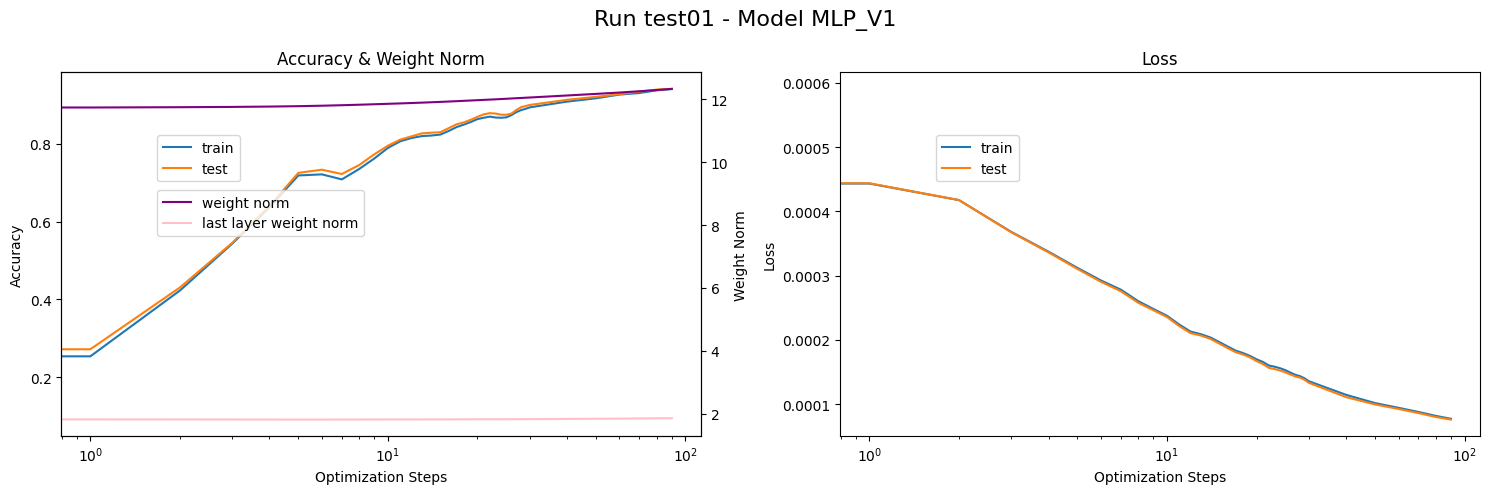

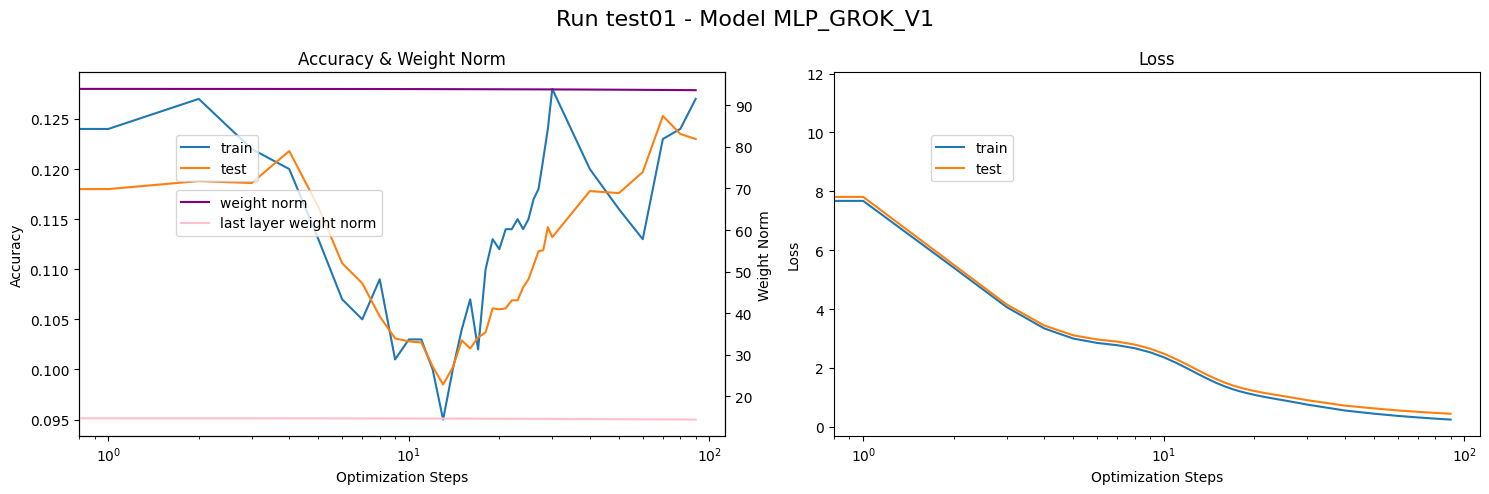

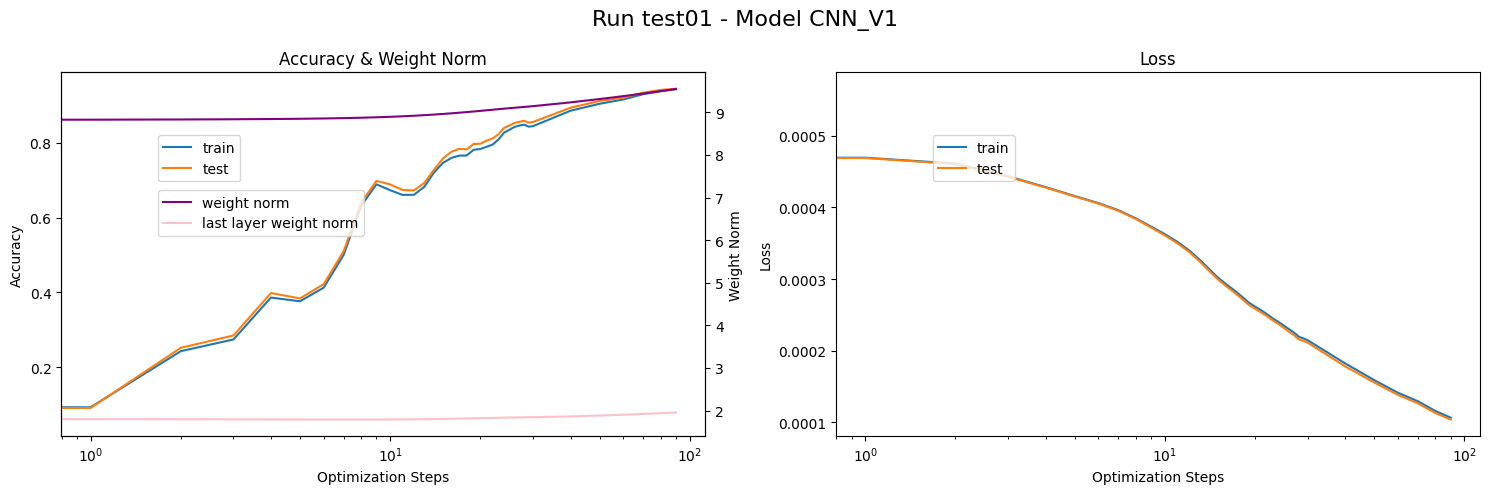

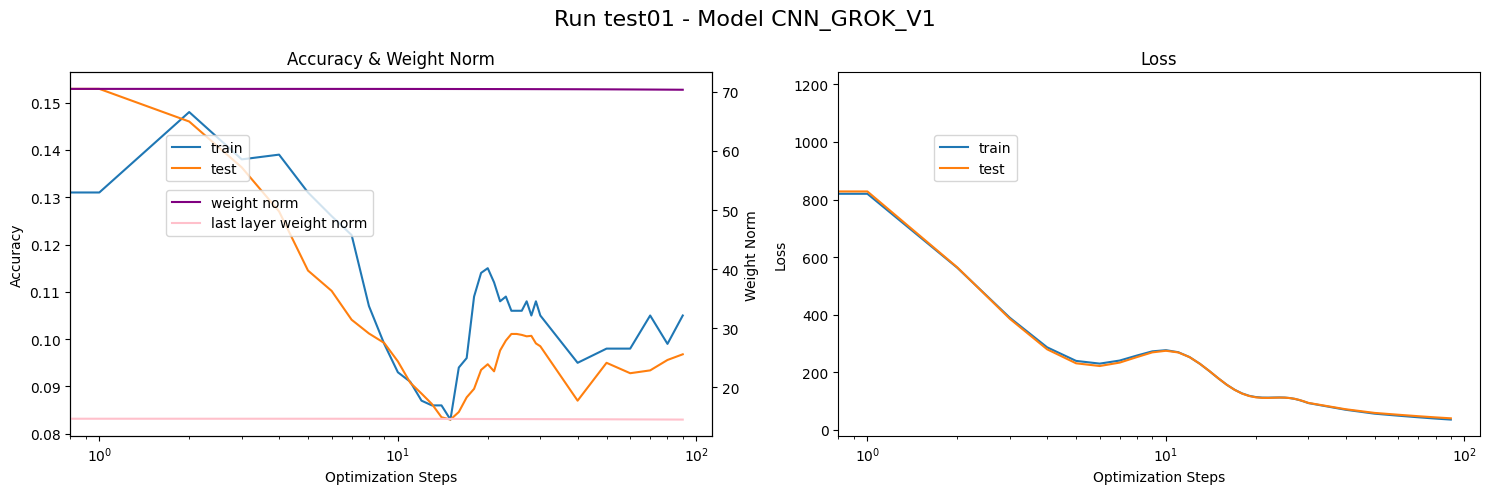

In [ ]:
for model, df in dfs.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Left subplot: Accuracy and Weight Norm
    ax1.set_xlabel("Optimization Steps")
    ax1.set_xscale('log')
    ax1.set_ylabel("Accuracy")
    ax1.plot(df["step"], df["train_accuracy"], label="train")
    ax1.plot(df["step"], df["test_accuracy"], label="test")
    ax1.legend(loc=(0.15, 0.7))
    
    ax1_twin = ax1.twinx()
    ax1_twin.set_ylabel("Weight Norm")
    ax1_twin.plot(df["step"], df["norm"], color="purple", label="weight norm")
    ax1_twin.plot(df["step"], df["last_layer_norm"], color="pink", label="last layer weight norm")
    ax1_twin.legend(loc=(0.15, 0.55))
    
    ax1.set_title("Accuracy & Weight Norm")
    
    # Right subplot: Loss
    ax2.set_xlabel("Optimization Steps")
    ax2.set_xscale('log')
    ax2.set_ylabel("Loss")
    ax2.plot(df["step"], df["train_loss"], label="train")
    ax2.plot(df["step"], df["test_loss"], label="test")
    ax2.legend(loc=(0.15, 0.7))
    ax2.set_title("Loss")
    
    # Overall title
    fig.suptitle("Run {} - Model {}".format(RUN_ID, model), fontsize=16)
    plt.tight_layout()
    plt.show()